In [1]:
import langgraph
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

In [2]:
import os

llm = ChatOpenAI(model=os.getenv("OPENAI_DEFAULT_MODEL"))

/tmp/ipykernel_65162/3971565783.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model=os.getenv("OPENAI_DEFAULT_MODEL"))


In [3]:
def code_style_check(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드의 스타일을 점검하고 PEP8 준수 여부를 확인하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["style_feedback"] = response.content
    return inputs

def bug_detection(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드에서 잠재적인 버그나 논리적 오류를 찾아 설명하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["bug_feedback"] = response.content
    return inputs

def optimization_suggestions(inputs):
    code = inputs["code"]
    prompt = (
        "다음 코드를 더 효율적으로 최적화할 수 있는 방법을 제안하세요:\n" + code
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    inputs["optimization_feedback"] = response.content
    return inputs

def aggregate_feedback(inputs):
    code = inputs["code"]
    feedback = (
        "코드 스타일 피드백:\n" + inputs["style_feedback"] + "\n\n"
        "버그 가능성 분석:\n" + inputs["bug_feedback"] + "\n\n"
        "최적화 제안:\n" + inputs["optimization_feedback"]
    )
    prompt = (
        "다음 코드와 피드백을 바탕으로 개선된 코드를 작성하세요. 반드시 코드만 출력해야 합니다.\n" + \
            "code: " + code + "\n\n" \
            "피드백: " + feedback
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"code": response.content, "final_feedback": feedback}

In [4]:
from langgraph.graph import END, Graph, START

# LangGraph 워크플로우 구축
graph = Graph()
graph.add_node("style_check", code_style_check)
graph.add_node("bug_check", bug_detection)
graph.add_node("optimization_check", optimization_suggestions)
graph.add_node("aggregate", aggregate_feedback)

# 데이터 흐름 정의
graph.add_edge(START, "style_check")
graph.add_edge("style_check", "bug_check")
graph.add_edge("bug_check", "optimization_check")
graph.add_edge("optimization_check", "aggregate")
graph.add_edge("aggregate", END)

app = graph.compile()


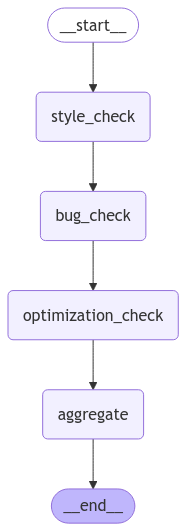

In [5]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
sample_code = """
def add_numbers(a, b):
return a+b
"""
result = app.invoke({"code": sample_code})
print(result["final_feedback"])

코드 스타일 피드백:
제공하신 코드는 PEP 8 스타일 가이드에 몇 가지 위반 사항이 있습니다. PEP 8은 Python 코드의 스타일을 일관되게 유지하기 위한 규칙입니다. 다음은 문제점과 수정 사항입니다.

1. **인덴트**: 함수의 본체는 반드시 들여쓰기가 필요합니다. `return` 문은 함수의 정의와 같은 수준으로 들여쓰기 되어야 합니다.
2. **연산자 주변의 공백**: `+` 연산자 주변에는 공백을 추가하는 것이 좋습니다.

수정된 코드는 다음과 같습니다:

```python
def add_numbers(a, b):
    return a + b
```

이 수정된 코드는 PEP 8 가이드라인을 준수합니다.

버그 가능성 분석:
제공된 코드에서 잠재적인 버그나 논리적 오류는 다음과 같습니다:

1. **들여쓰기 문제**: 파이썬에서는 들여쓰기가 매우 중요합니다. `return` 문이 `add_numbers` 함수의 본문에 포함되어야 하는데, 현재 코드에서는 들여쓰기가 되어 있지 않아 문법 오류(SyntaxError)가 발생합니다. 올바른 코드는 다음과 같아야 합니다:

    ```python
    def add_numbers(a, b):
        return a + b
    ```

2. **입력 값의 타입 검증**: 함수는 두 개의 입력 값을 받아서 더합니다. 그러나 입력 값이 숫자(예: 정수 또는 실수)인지 확인하지 않으면, 사용자가 문자열이나 다른 타입을 입력했을 때 TypeError가 발생할 수 있습니다. 예를 들어, `add_numbers("1", "2")`와 같이 호출하면 문자열이 더해져서 예상치 못한 결과가 발생할 수 있습니다. 이를 방지하기 위해 입력 값의 타입을 검증하거나 예외 처리를 추가하는 것이 좋습니다. 예를 들어:

    ```python
    def add_numbers(a, b):
        if not (isinstance(a, (int, float)) and isinstance(b, (int, flo

In [7]:
print(result["code"])

```python
def add_numbers(*args: float) -> float:
    """
    여러 숫자를 더합니다.

    :param args: 더할 숫자들
    :return: 모든 숫자의 합
    """
    if not all(isinstance(x, (int, float)) for x in args):
        raise ValueError("모든 인자는 숫자여야 합니다.")
    return sum(args)
```
